# LetsGrowMore (LGMVIP- APRIL2022)
## Author Name - Pavan Wanjari
## Task 2 - Stock Market Prediction And Forecasting Using Stacked LSTM
### Datasetlinks: : https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv


In this model I used the Stacked LSTM(Long Short Term Memory). A Machine Learning Model for Stock Market Prediction. Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on a financial exchange.

## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
stock_df = pd.read_csv("NSE-TATAGLOBAL.csv")
stock_df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


## Data Exploration

In [3]:
# check shape of data
stock_df.shape

(2035, 8)

In this dataset we have 2035 rows and 8 columns 

In [4]:
# check basic info of data
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [5]:
# get statistical summaries of dataset
stock_df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [6]:
# check is there any null values present of not
stock_df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

Here we can see no null values present in dataset

## Exploratory Data Analysis (EDA)

### Data visualization

In [7]:
stock_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

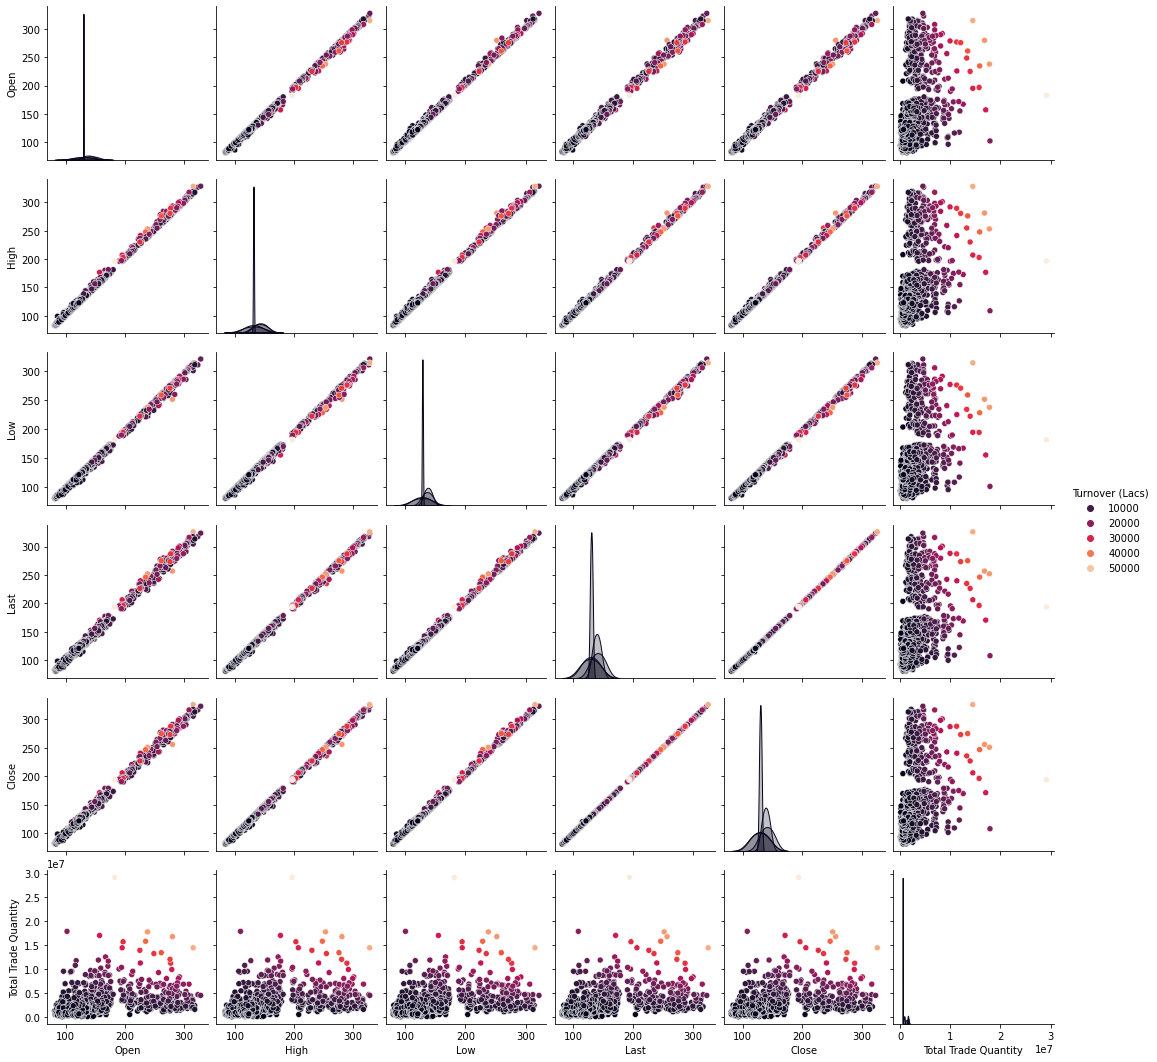

In [8]:
sns.pairplot(stock_df, hue= 'Turnover (Lacs)', palette= "rocket")
plt.show()

In [9]:
df_close=stock_df.reset_index()['Close']
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

* **Let us plot the Close value graph using pyplot**


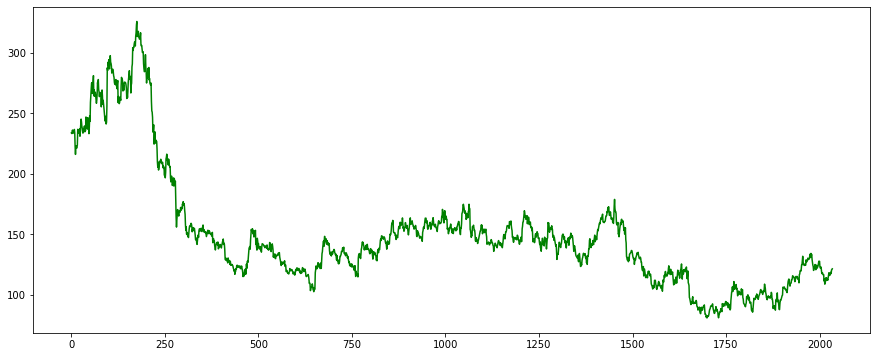

In [10]:
plt.figure(figsize=(15,6))
plt.plot(df_close, c= "g")
plt.show()

* **Let us plot the High value graph using pyplot**


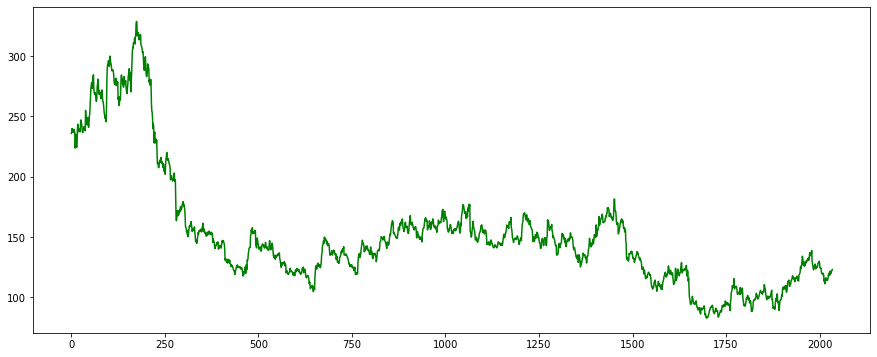

In [11]:
plt.figure(figsize=(15,6))

df_high=stock_df.reset_index()['High']
plt.plot(df_high, c="g")
plt.show()

* **Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1**


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1,1))

In [13]:
df_high.shape

(2035, 1)

In [14]:
print(df_high)

[[0.62268754]
 [0.62614353]
 [0.6391543 ]
 ...
 [0.15917869]
 [0.15938199]
 [0.16344786]]


**Train Test Split**
* In time-series data the one data is dependent on other data. The training size should be 75% of the total length of the data frame, the test size should be the difference between the length of the dataset and the training size.


In [15]:
training_size = int(len(df_high) * 0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size,:], df_high[training_size:len(df_high),:1]

In [16]:
training_size,test_size

(1526, 509)

### Data Preprocessing

In [17]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

### LSTM

* Reshape the input to be [samples, time steps, features] which is the requirement of LSTM


In [19]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [20]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [21]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

* **Import required modules for the stacked LSTM.**

In [22]:
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

In [23]:
#checking my tensorflow version
tf.__version__

'2.8.0'

In [24]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 40s 942ms/step - loss: 0.0285 - val_loss: 0.0043
Epoch 2/100
23/23 [==============================] - 20s 862ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 3/100
23/23 [==============================] - 20s 851ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/100
23/23 [==============================] - 31s 1s/step - loss: 0.0013 - val_loss: 9.7704e-04
Epoch 5/100
23/23 [==============================] - 20s 873ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
23/23 [==============================] - 20s 888ms/step - loss: 0.0012 - val_loss: 9.5420e-04
Epoch 7/100
23/23 [==============================] - 20s 864ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
23/23 [==============================] - 21s 911ms/step - loss: 0.0011 - val_loss: 9.8788e-04
Epoch 9/100
23/23 [==============================] - 20s 863ms/step - loss: 0.0010 - val_loss: 9.2632e-04
Epoch 10/100
23/23 [==============================] - 21s 899ms/step 

23/23 [==============================] - 19s 829ms/step - loss: 2.1325e-04 - val_loss: 1.6905e-04
Epoch 76/100
23/23 [==============================] - 19s 825ms/step - loss: 1.8709e-04 - val_loss: 2.5266e-04
Epoch 77/100
23/23 [==============================] - 19s 836ms/step - loss: 2.4917e-04 - val_loss: 1.6463e-04
Epoch 78/100
23/23 [==============================] - 19s 811ms/step - loss: 3.2060e-04 - val_loss: 2.1213e-04
Epoch 79/100
23/23 [==============================] - 20s 868ms/step - loss: 2.0663e-04 - val_loss: 1.8055e-04
Epoch 80/100
23/23 [==============================] - 19s 815ms/step - loss: 2.1119e-04 - val_loss: 1.6447e-04
Epoch 81/100
23/23 [==============================] - 19s 819ms/step - loss: 2.0058e-04 - val_loss: 2.2404e-04
Epoch 82/100
23/23 [==============================] - 20s 881ms/step - loss: 1.9004e-04 - val_loss: 1.4952e-04
Epoch 83/100
23/23 [==============================] - 19s 817ms/step - loss: 2.7477e-04 - val_loss: 1.9467e-04
Epoch 84/100
2

In [27]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [28]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

164.49258446995975

In [30]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

107.39751932277417

### Plotting the graph according to train and test data

In [31]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_high) - 1, :] = test_predict

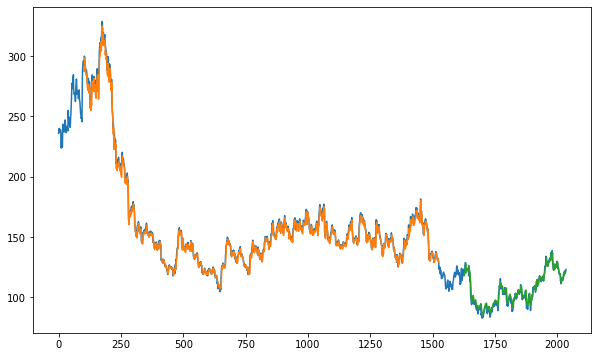

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data


In [32]:
#Plot baseline and predictions
plt.figure(figsize=(10,6))

plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green indicates the Predicted Data")
print("Blue indicates the Complete Data")
print("Orange indicates the Train Data")

In [33]:
#Predict the next 28 days Stock Price
len(test_data), x_test.shape

(509, (408, 100, 1))

In [34]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

### Predicting values for next 30 days

In [35]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.1612018]
101
1 day input [0.13254727 0.13397032 0.13356373 0.13498679 0.14108559 0.13498679
 0.12644847 0.12685505 0.12482212 0.14515145 0.1467778  0.15003049
 0.15368977 0.17198618 0.16548079 0.17625534 0.17564546 0.19129904
 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727  0.17483228
 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892 0.18987599
 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665
 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754
 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372
 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426 0.16853019
 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839
 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654
 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037
 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811
 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385
 0.12807481 0.12624517 0.13051433 

8 day output [[0.15532534]]
9 day input [0.12482212 0.14515145 0.1467778  0.15003049 0.15368977 0.17198618
 0.16548079 0.17625534 0.17564546 0.19129904 0.20817239 0.20309006
 0.18479366 0.17930474 0.1896727  0.17483228 0.17849156 0.17645863
 0.18540354 0.18377719 0.19190892 0.18987599 0.19028258 0.19394186
 0.20004066 0.19638138 0.19495832 0.20349665 0.19597479 0.21162838
 0.22036999 0.20979874 0.21528766 0.21589754 0.21610083 0.22748526
 0.19150234 0.1833706  0.17340923 0.16751372 0.1622281  0.17056312
 0.17462899 0.17930474 0.18174426 0.16853019 0.16548079 0.1742224
 0.1713763  0.17300264 0.17157959 0.17767839 0.18459036 0.18702988
 0.18987599 0.19109575 0.18581012 0.17015654 0.16751372 0.16974995
 0.16609067 0.15531612 0.15003049 0.15064037 0.14860744 0.14596463
 0.15043708 0.14413499 0.12441553 0.12827811 0.11547062 0.12034966
 0.13478349 0.13498679 0.12868469 0.13295385 0.12807481 0.12624517
 0.13051433 0.13905265 0.14718439 0.15104696 0.14515145 0.14311852
 0.15816223 0.15328319 

16 day output [[0.15093069]]
17 day input [0.17564546 0.19129904 0.20817239 0.20309006 0.18479366 0.17930474
 0.1896727  0.17483228 0.17849156 0.17645863 0.18540354 0.18377719
 0.19190892 0.18987599 0.19028258 0.19394186 0.20004066 0.19638138
 0.19495832 0.20349665 0.19597479 0.21162838 0.22036999 0.20979874
 0.21528766 0.21589754 0.21610083 0.22748526 0.19150234 0.1833706
 0.17340923 0.16751372 0.1622281  0.17056312 0.17462899 0.17930474
 0.18174426 0.16853019 0.16548079 0.1742224  0.1713763  0.17300264
 0.17157959 0.17767839 0.18459036 0.18702988 0.18987599 0.19109575
 0.18581012 0.17015654 0.16751372 0.16974995 0.16609067 0.15531612
 0.15003049 0.15064037 0.14860744 0.14596463 0.15043708 0.14413499
 0.12441553 0.12827811 0.11547062 0.12034966 0.13478349 0.13498679
 0.12868469 0.13295385 0.12807481 0.12624517 0.13051433 0.13905265
 0.14718439 0.15104696 0.14515145 0.14311852 0.15816223 0.15328319
 0.14921732 0.15531612 0.15917869 0.15938199 0.16344786 0.1612018
 0.16128556 0.16065887

25 day output [[0.14841191]]
26 day input [0.17645863 0.18540354 0.18377719 0.19190892 0.18987599 0.19028258
 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665 0.19597479
 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754 0.21610083
 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372 0.1622281
 0.17056312 0.17462899 0.17930474 0.18174426 0.16853019 0.16548079
 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839 0.18459036
 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654 0.16751372
 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037 0.14860744
 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811 0.11547062
 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385 0.12807481
 0.12624517 0.13051433 0.13905265 0.14718439 0.15104696 0.14515145
 0.14311852 0.15816223 0.15328319 0.14921732 0.15531612 0.15917869
 0.15938199 0.16344786 0.1612018  0.16128556 0.16065887 0.15978853
 0.15883964 0.15788825 0.15697412 0.15611725 0.15532534 0.15459861
 0.15393333 0.1533239

In [36]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)


In [37]:
day_new.shape

(100,)

In [38]:
day_pred.shape

(28,)

In [39]:
ds3 = df_high.tolist()
ds3.extend(lst_output)

len(df_high)

2035

* **Graph of actual values in last 100 days**


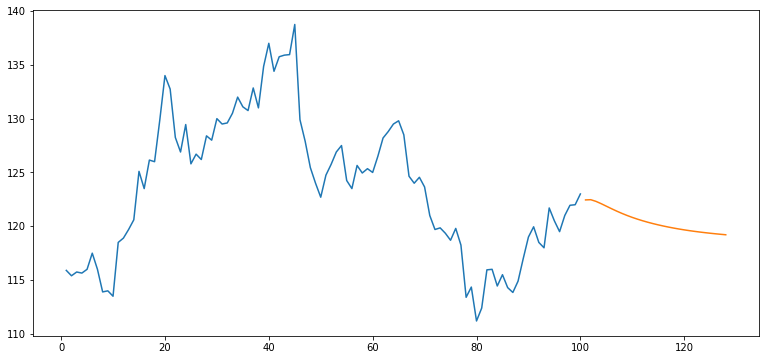

In [43]:
plt.figure(figsize=(13,6))

plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

plt.show()

* **Graph of predicted values for next 30 days**

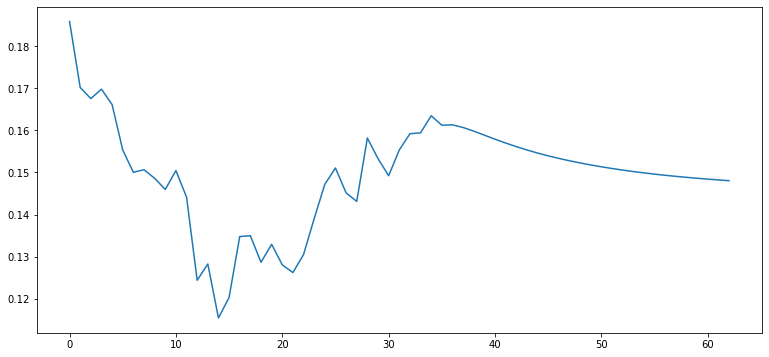

In [45]:
plt.figure(figsize=(13,6))

ds3=df_high.tolist()
ds3.extend(lst_output)
plt.plot(ds3[2000:])
plt.show()

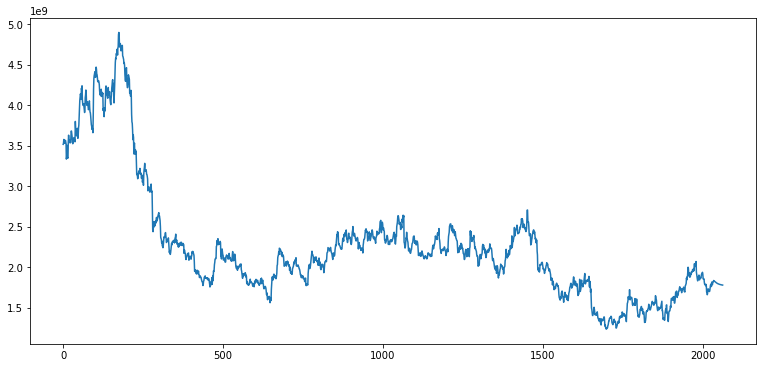

In [49]:
plt.figure(figsize=(13,6))

ds3=scaler.inverse_transform(ds3).tolist()
plt.plot(ds3)

plt.show()

### Model Created Successfully !
## Thank You!